# Ejercicio 2.5

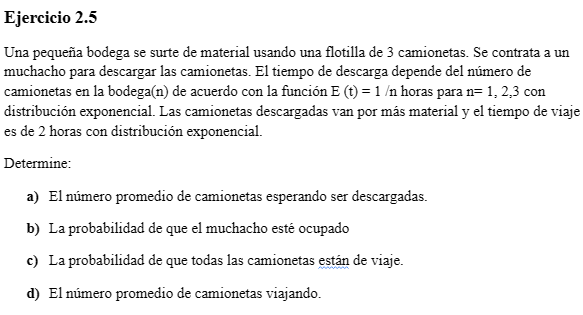

## Dessarrollo en Simpy


Instalacion de libreria

In [7]:
pip install simpy

Importaciones nescesarias

In [6]:
import simpy
import random

Simulacion

In [25]:
# Parámetros de entrada
t_rho_media_descarga = {n: 1/n for n in [1,2,3]}
t_media_viaje = 2.0
T = 100.0
num_camionetas = 3

# Variables de estado y acumuladores
env = None
n_waiting = 0
n_in_service = 0
n_traveling = 0
area_all_traveling = 0.0
arrival_queue = []

area_waiting = 0.0
area_traveling = 0.0
last_event_time = 0.0

t_busy_operario = 0.0
busy_start = None
sum_waiting_time = 0.0
count_descargas = 0


def update_stats():
    """Actualiza integrales y tiempos ocupados."""
    global area_waiting, area_traveling, area_all_traveling, last_event_time, t_busy_operario
    now = env.now
    dt = now - last_event_time
    # Área de espera
    area_waiting += n_waiting * dt
    # Área de camionetas en viaje
    area_traveling += n_traveling * dt
    # Área cuando todas viajan
    if n_traveling == num_camionetas:
        area_all_traveling += dt
    # Tiempo ocupado del operario
    if n_in_service > 0:
        t_busy_operario += dt
    last_event_time = now


def Init(environment):
    """Inicializa el sistema y programa eventos iniciales."""
    global env, n_traveling, last_event_time
    env = environment
    n_traveling = num_camionetas
    last_event_time = 0.0

    for vid in range(num_camionetas):
        env.process(FinViaje(vid))


def ArriboVeh(vid):
    """Evento: camioneta entra a cola de descarga."""
    global n_waiting, arrival_queue, n_traveling
    update_stats()
    n_traveling -= 1
    n_waiting += 1
    arrival_queue.append(env.now)

    if n_in_service == 0:
        env.process(FinDescarga())


def FinDescarga():
    """Evento: operario termina descarga de una camioneta."""
    global n_waiting, n_in_service, sum_waiting_time, count_descargas, n_traveling
    update_stats()
    # Iniciar servicio
    n_waiting -= 1
    n_in_service = 1
    # calcular tiempo de espera
    t_arr = arrival_queue.pop(0)
    sum_waiting_time += (env.now - t_arr)
    # descargar (media 1/n horas según número en servicio previo)
    descarga_time = random.expovariate(1.0 / t_rho_media_descarga[n_waiting+1])
    yield env.timeout(descarga_time)
    update_stats()
    # finalizar descarga
    n_in_service = 0
    count_descargas += 1
    n_traveling += 1
    # programar viaje y próximo arribo
    env.process(FinViaje(vid=None))
    # si quedan esperando, iniciar siguiente descarga
    if n_waiting > 0:
        env.process(FinDescarga())


def FinViaje(vid):
    """Evento: camioneta termina viaje y llega para descarga."""
    global n_traveling
    viaje_time = random.expovariate(1.0 / t_media_viaje)
    yield env.timeout(viaje_time)
    ArriboVeh(vid)


def Report():
    """Calcula y muestra medidas de desempeño."""
    update_stats()
    L_q = area_waiting / T
    L_v = area_traveling / T
    W_q = sum_waiting_time / count_descargas if count_descargas>0 else 0
    rho = (t_busy_operario / T) * 100
    p_all_travel = (area_all_traveling / T) * 100
    print("Los resultados obtenidos de la simulacion son: \n")
    print(f"Número promedio de camionetas esperando descarga: {L_q:.2f} camionetas")
    print(f"Número promedio de camionetas en viaje: {L_v:.2f} camionetas")
    print(f"Tiempo promedio de espera en cola: {W_q:.2f} horas")
    print(f"Probabilidad de que todas las camionetas estén viajando: {p_all_travel:.1f}%")
    print(f"Probabilidad del que el operario este ocupado: {rho:.2f}%")


def Run():
    """Orquesta la simulación completa."""
    environment = simpy.Environment()
    Init(environment)
    environment.run(until=T)
    Report()


if __name__ == "__main__":
    Run()

Los resultados obtenidos de la simulacion son: 

Número promedio de camionetas esperando descarga: 0.37 camionetas
Número promedio de camionetas en viaje: 2.00 camionetas
Tiempo promedio de espera en cola: 0.42 horas
Probabilidad de que todas las camionetas estén viajando: 37.2%
Probabilidad del que el operario este ocupado: 62.75%


## Desarrollo Simlib

### Libreria Simlib en C

In [28]:
%%writefile simlib.h
#ifndef SIMLIB_H
#define SIMLIB_H

/* Reloj de simulación */
extern double STime;

/* Inicializa la librería (reinicia reloj y estadísticas) */
void InitSimlib(void);

/* Programa un evento: función fn() tras delay horas */
void Schedule(void (*fn)(void), double delay);

/* Generador exponencial con media mean */
double Exponential(double mean);

/* Ejecuta la simulación: init(), bucle de eventos hasta time_limit, luego report() */
void RunSimulation(void (*init)(void), double time_limit, void (*report)(void));

#endif /* SIMLIB_H */

Writing simlib.h


In [30]:
%%writefile simlib.c
#include "simlib.h"
#include <stdlib.h>
#include <stdio.h>
#include <math.h>

#define MAX_EVENTS 10000

typedef struct {
    double time;
    void (*fn)(void);
} Event;

static Event event_list[MAX_EVENTS];
static int event_count;

double STime = 0.0;

/* Inserta evento ordenado por tiempo */
static void insert_event(double t, void (*fn)(void)) {
    int i = event_count++;
    while (i > 0 && event_list[i-1].time > t) {
        event_list[i] = event_list[i-1];
        i--;
    }
    event_list[i].time = t;
    event_list[i].fn   = fn;
}

/* Extrae el siguiente evento */
static Event pop_event(void) {
    Event e = event_list[0];
    for (int i = 1; i < event_count; i++)
        event_list[i-1] = event_list[i];
    event_count--;
    return e;
}

void InitSimlib(void) {
    STime = 0.0;
    event_count = 0;
}

void Schedule(void (*fn)(void), double delay) {
    double t = STime + delay;
    insert_event(t, fn);
}

double Exponential(double mean) {
    return -mean * log(drand48());
}

void RunSimulation(void (*init)(void), double time_limit, void (*report)(void)) {
    InitSimlib();
    init();
    while (event_count > 0) {
        Event e = pop_event();
        if (e.time > time_limit) break;
        STime = e.time;
        e.fn();
    }
    /* Avanzar reloj para cerrar integrales */
    STime = time_limit;
    report();
}


Writing simlib.c


### Simulación

In [33]:
%%writefile simulacion.c

#include "simlib.h"
#include <stdio.h>

/* Parámetros de entrada */
double t_rho_media_descarga[4]; /* índices 1..3 */
double t_media_viaje;
double T;
int num_camionetas;

/* Variables de estado y acumuladores */
double area_waiting=0, area_traveling=0, area_all_traveling=0;
double last_event_time=0, t_busy_operario=0;
int n_waiting=0, n_in_service=0, n_traveling=0;
double sum_waiting_time=0;
int count_descargas=0;

/* Cola FIFO para tiempos de arribo */
#define QSIZE 10000
double arrival_queue[QSIZE];
int q_head=0, q_tail=0;

/* Prototipos de eventos y rutinas */
void Init(void);
void ArriboVeh(void);
void StartDescarga(void);
void EndDescarga(void);
void FinViaje(void);
void update_stats(void);
void Report(void);

/* Actualiza estadísticas de área y ocupación */
void update_stats(void) {
    double now = STime;
    double dt = now - last_event_time;
    area_waiting   += n_waiting * dt;
    area_traveling += n_traveling * dt;
    if (n_traveling == num_camionetas)
        area_all_traveling += dt;
    if (n_in_service > 0)
        t_busy_operario += dt;
    last_event_time = now;
}

/* Inicialización */
void Init(void) {
    n_traveling = num_camionetas;
    last_event_time = 0;
    q_head = q_tail = 0;
    for (int i = 0; i < num_camionetas; i++) {
        Schedule(FinViaje, 0.0);
    }
}

/* Evento de llegada tras viaje */
void ArriboVeh(void) {
    update_stats();
    n_traveling--;
    n_waiting++;
    arrival_queue[q_tail++] = STime;
    if (n_in_service == 0)
        Schedule(StartDescarga, 0.0);
}

/* Inicia el servicio de descarga */
void StartDescarga(void) {
    update_stats();
    n_waiting--;
    n_in_service = 1;
    double t_arr = arrival_queue[q_head++];
    sum_waiting_time += (STime - t_arr);
    double descarga_time = Exponential(t_rho_media_descarga[n_waiting + 1]);
    Schedule(EndDescarga, descarga_time);
}

/* Termina el servicio de descarga */
void EndDescarga(void) {
    update_stats();
    n_in_service = 0;
    count_descargas++;
    n_traveling++;
    Schedule(FinViaje, 0.0);
    if (n_waiting > 0)
        Schedule(StartDescarga, 0.0);
}

/* Evento fin de viaje */
void FinViaje(void) {
    double viaje_time = Exponential(t_media_viaje);
    Schedule(ArriboVeh, viaje_time);
}

/* Reporte al final */
void Report() {
    update_stats();

    double L_q = area_waiting / T;
    double L_v = area_traveling / T;
    double W_q = (count_descargas > 0) ? sum_waiting_time / count_descargas : 0;
    double rho = (t_busy_operario / T) * 100;
    double p_all_travel = (area_all_traveling / T) * 100;

    printf("Los resultados obtenidos de la simulacion son: \n\n");
    printf("Numero promedio de camionetas esperando descarga: %.2f camionetas\n", L_q);
    printf("Numero promedio de camionetas en viaje: %.2f camionetas\n", L_v);
    printf("Tiempo promedio de espera en cola: %.2f horas\n", W_q);
    printf("Probabilidad de que todas las camionetas esten viajando: %.1f%%\n", p_all_travel);
    printf("Probabilidad del que el operario este ocupado: %.2f%%\n", rho);
}

int main(void) {
    /* Parámetros */
    t_rho_media_descarga[1]=1.0;
    t_rho_media_descarga[2]=0.5;
    t_rho_media_descarga[3]=0.333333;
    t_media_viaje=2.0;
    T=100.0;
    num_camionetas=3;

    RunSimulation(Init, T, Report);
    return 0;
}


Overwriting simulacion.c


Ejecucion de la simulación

In [36]:
%%bash
gcc simlib.c simulacion.c -o simulacion -lm
./simulacion

Los resultados obtenidos de la simulacion son: 

Numero promedio de camionetas esperando descarga: 0.24 camionetas
Numero promedio de camionetas en viaje: 2.16 camionetas
Tiempo promedio de espera en cola: 0.39 horas
Probabilidad de que todas las camionetas esten viajando: 39.9%
Probabilidad del que el operario este ocupado: 60.09%
